## Второй этап

Теперь нам известна эволюционно устойчивая стратегия поведения $x=A+Bcos(2\pi \cdot t)$
$$A=-85, B=-50$$
Составим вектор вертикальны
$$x^*=(x(0), x(\frac{1}{n}), x(\frac{2}{n}),...,x(\frac{n}{n}))$$
$$t\in(0,1)$$

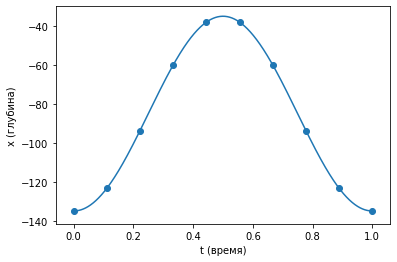

In [168]:
import numpy as np
import matplotlib.pyplot as plt 


A = -85
B = -50
C0 = 60
C = 140

def x(t):
    return A + B * np.cos(2 * np.pi * t)

n = 10

t_space_n = np.linspace(0, 1, n)
t_space_real = np.linspace(0, 1, 1000)
x_star = [x(t) for t in t_space_n]

plt.plot(t_space_real, x(t_space_real))
plt.scatter(t_space_n, x_star)
plt.xlabel('t (время)')
plt.ylabel('x (глубина)')
plt.show()

Сгенерируем новые стратегии поведения по такому принципу:

deВыберем случайное число от 1 до $n$, обозначим его $k$. Теперь выберем $k$ случайных различных чисел $m_i$, $i=1,..k$ от $m_i \in \{1,...,n\}$ и проведем случайные сдвиги $c_{m_i}$ по координатам $x_{m_i}$. Таким образом генерируется новая стратегия поведения.  

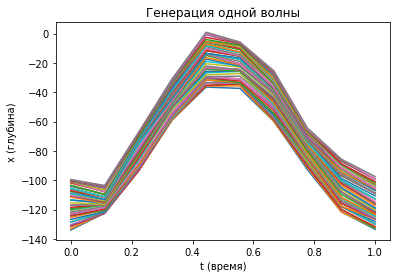

In [169]:
import pandas as pd

numbers = [i for i in range(n)]
state = np.random.RandomState(12345)


def gen_k_numbers(k):
    m = pd.Series(numbers).sample(n=k, random_state=state)
    return list(m)

wave_n = 10
wave = []
def gen_wave(x, m, i, t):
    if i >= wave_n:
        return
    for j in range(len(m)):
        x[m[j]] += (-1) ** t  * np.random.random()
    wave.append(x)
    k = np.random.randint(n, size=1)
    new_m = gen_k_numbers(k)
    gen_wave(x[:], new_m, i + 1, t)

def gen_wave_until_ground(x, m, t):
    for i in range(len(x)):
        if x[i] >= 0 or x[i] <= -C:
            return
    for j in range(len(m)):
        x[m[j]] += (-1) ** t * 2 * np.random.random()
    wave.append(x)
    k = np.random.randint(n, size=1)
    new_m = gen_k_numbers(k)
    gen_wave_until_ground(x[:], new_m, t)
    
k = np.random.randint(n, size=1)
m = gen_k_numbers(k)
gen_wave_until_ground(x_star[:], m, 0)
for i in range(len(wave)):
    plt.plot(t_space_n, wave[i])
plt.xlabel('t (время)')
plt.ylabel('x (глубина)')
plt.title('Генерация одной волны')
plt.show()

In [170]:
wave = []
def get_l_waves(l):
    global wave
    strats = []
    for i in range(l):
        k = np.random.randint(n, size=1)
        m = gen_k_numbers(k)
        gen_wave(x_star[:], m, 0, (-1) ** i)
        for i in range(len(wave)):
            for j in range(i + 1, len(wave)):
                if wave[i] != wave[j]:
                    strats.append((wave[i], wave[j], 1))
                    strats.append((wave[j], wave[i], -1))
        wave = []
    return strats

strats = get_l_waves(10)
len(strats)

884

## Напишем функции подсчета интегралов
$$
R(x) = \int\limits_0^1 \alpha E(x)\,dt - \int\limits_0^1 \gamma S_x(x) (cos(2\pi t) + 1)\,dt - \int\limits_0^1 \beta (x')^2\,dt  - \int\limits_0^1 \delta G(x)\,dt 
$$ где $x$ - стратегия поведения.

Аппроксимации функций состояния окружающей среды:

$$E = \sigma_1 (x + C), -C < x < 0 \\
S_x = \sigma_2 (x + C) \\
S_t=cos(2\pi t) + 1, 0 < t < 1 \\
G = (x + C_0)^2
$$

In [171]:
sigm1 = 0.25
sigm2 = 0.003



def E(x, t):
    return sigm1 * (x + C)

def S_x_S_t(x, t):
    return sigm2 * (x + C) * (np.cos(2 * np.pi * t) + 1)

def G(x, t):
    return (x + C0) * (x + C0)

def integr(f, x):
    res = 0
    for i in range(len(x) - 1):
        res += (f(x[i + 1], (i + 1) / n) + f(x[i], i / n)) / (2 * n)
    return res

def M_0(x):
    return integr(E, x)

def M_1(x):
    return -integr(S_x_S_t, x)

def M_2(x):
    res = 0
    for i in range(len(x) - 1):
        res += ((x[i + 1] - x[i]) / n) * ((x[i + 1] - x[i]) / n)
    return -res

def M_3(x):
    return -integr(G, x)

def M(x):
    return M_0(x), M_1(x), M_2(x), M_3(x)

Принцип сравнения:
Возьмем две стратегии поведения $u$ и $v$. Можно посчитать отклонение от эволюционно устойчивой стратегии поведения $x^*$. $\epsilon_1 = u - x^*$, $\epsilon_2 = v - x^*$. И сравнить отклонения $\epsilon_1 - \epsilon_2 = u - v$. Если $\epsilon_1 - \epsilon_2 > 0$, значит отклонение $u$ от эволюционно устойчивой стратегии поведения $x^*$ больше, чем отклонение $v$ от $x^*$. Следовательно $v$ более приспособлена, чем $u$, т.к. находится 'ближе' к $x^*$.

In [172]:
import pandas as pd

"""
def get_params(u, v):
    k = [0] * len(u)
    for i in range(len(u)):
        k[i] = u[i] - v[i]
    ok_1 = True
    for elem in k:
        if elem < 0:
            ok_1 = False
            break
    ok_0 = True
    for elem in k:
        if elem > 0:
            ok_0 = False
            break
    zero = True
    for elem in k:
        if elem != 0:
            zero = False
    if zero:
        return False
    if ok_0:
        return [*(np.array(M(u)) - np.array(M(v))), 1]
    if ok_1:
        return [*(np.array(M(u)) - np.array(M(v))), -1]
    return False
 

    
def get_data_train_classifier(strat_b):
    train_data_arr = []
    for i in range(len(strat_b)):
        for j in range(i + 1, len(strat_b)):
            obj1 = get_params(strat_b[i], strat_b[j])
            obj2 = get_params(strat_b[j], strat_b[i])
            if obj1 is not False:
                train_data_arr.append(obj1)
                train_data_arr.append(obj2)
    train_data_classifier = pd.DataFrame(columns=['M_0', 'M_1', 'M_2', 'M_3', 'y'], data=train_data_arr)
    return train_data_classifier
    """ 

def get_params(strat):
    u = strat[0]
    v = strat[1]
    return [*(np.array(M(u)) - np.array(M(v))), strat[2]]
    
    
def gen_data_train(strats):
    train_data_arr = []
    for i in range(len(strats)):
        train_data_arr.append(get_params(strats[i]))
    train_data_classifier = pd.DataFrame(columns=['M_0', 'M_1', 'M_2', 'M_3', 'y'], data=train_data_arr)
    return train_data_classifier
    
data_train_classifier = gen_data_train(strats)
data_train_classifier['y'].value_counts()

 1    442
-1    442
Name: y, dtype: int64

In [173]:
from sklearn.linear_model import Perceptron


def normalize(X):
    max_M = [0] * 4;
    X_norm = pd.DataFrame()
    max_M[0] = max(X['M_0'])
    max_M[1] = max(X['M_1'])
    max_M[2] = max(X['M_2'])
    max_M[3] = max(X['M_3'])
    X_norm['M_0_norm'] = X['M_0'] / max_M[0]
    X_norm['M_1_norm'] = X['M_1'] /  max_M[1]
    X_norm['M_2_norm'] = X['M_2'] /  max_M[2]
    X_norm['M_3_norm'] = X['M_3'] /  max_M[3]
    return X_norm, max_M;


X = data_train_classifier.drop('y', axis=1)
y = data_train_classifier['y']


X_normalized, max_M = normalize(X);

In [174]:
model_norm = Perceptron()
model_norm.fit(X_normalized, y, coef_init=[0,0,0,0])
model = Perceptron()
model.fit(X, y, coef_init=[0,0,0,0])
print()

Веса модели с нормализаванными признаками  [1.2094051951093037, -1.0909983844994886, -0.041663092092504406, 1.155016940544935]
Веса исходной модели  [1.7806101026104308, -143.37493324372983, -0.01952593740368631, 0.007959247751873878]
Заранее известные коэффициенты lam  [2, 333, 2.5e-05, 0.01]
Частота правильных ответов на обучающей выборке  1.0
Косинус угла между векторами lam и model_coef -0.9998302598236919


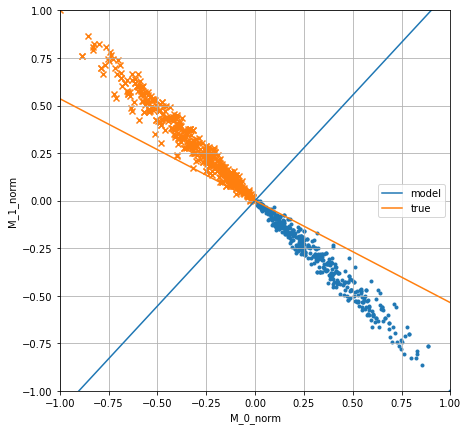

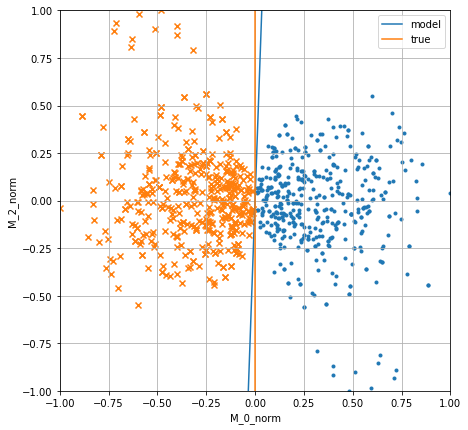

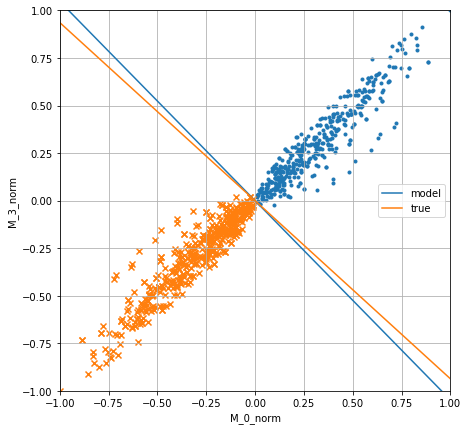

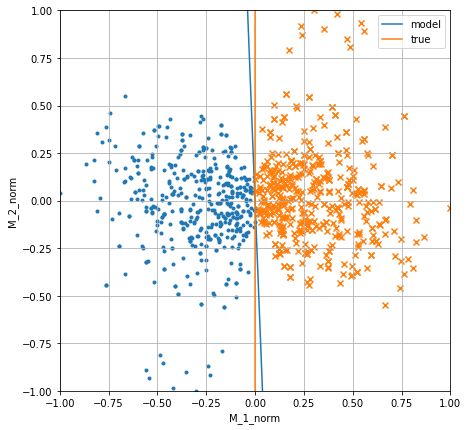

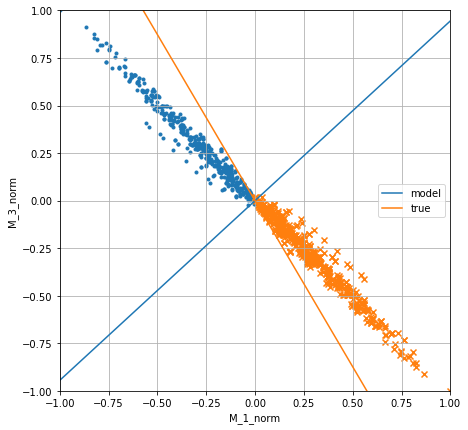

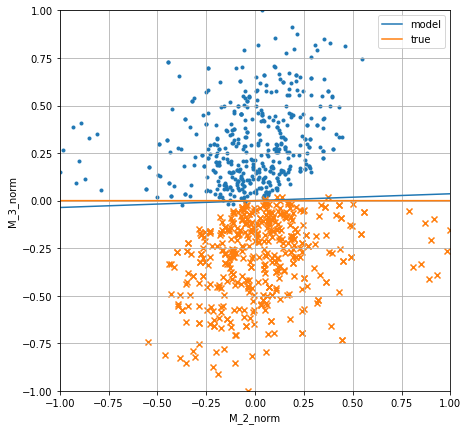

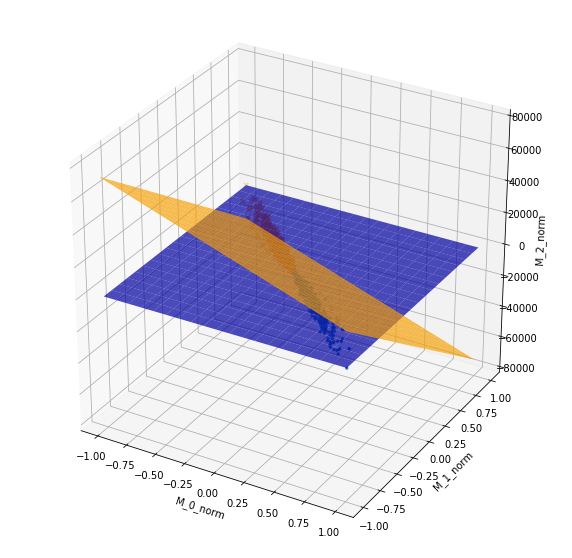

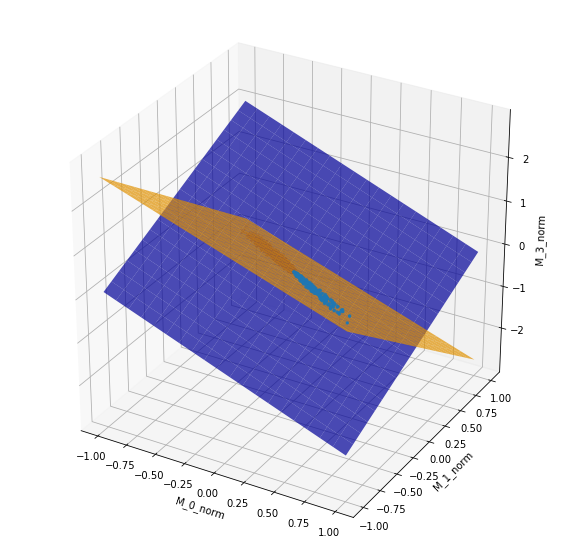

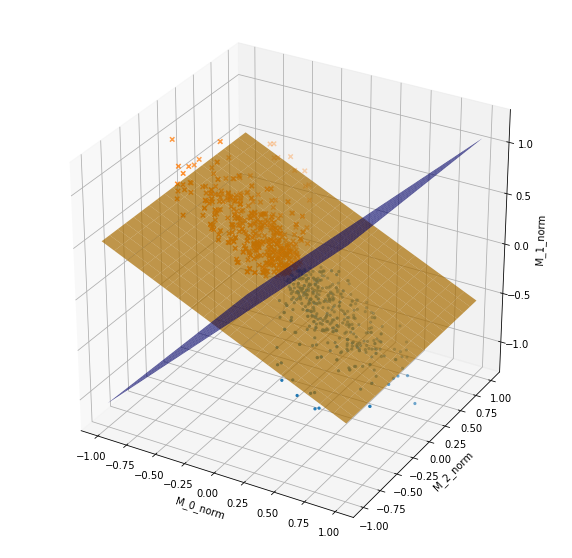

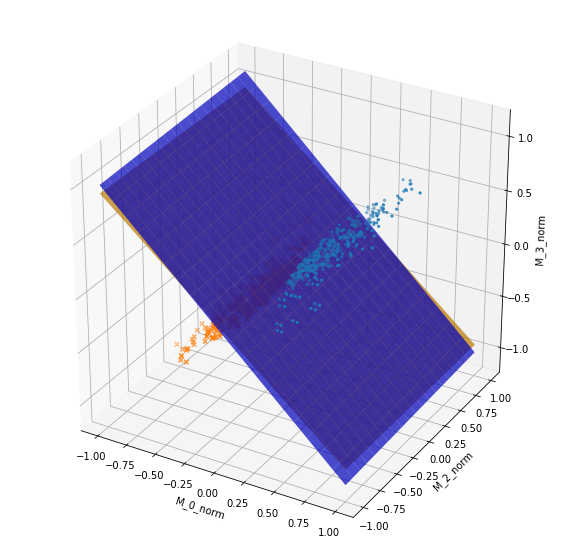

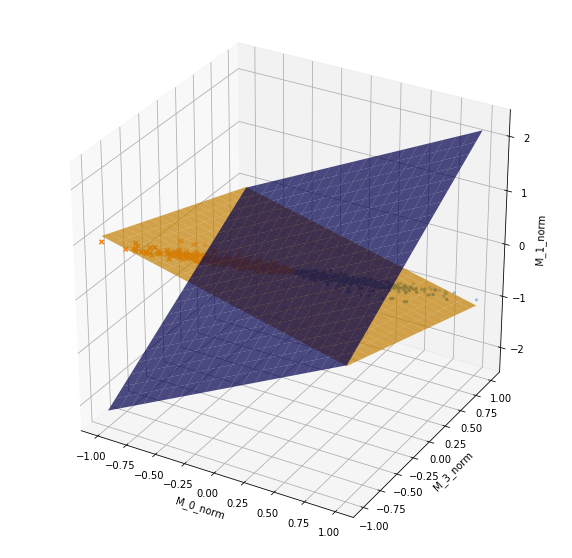

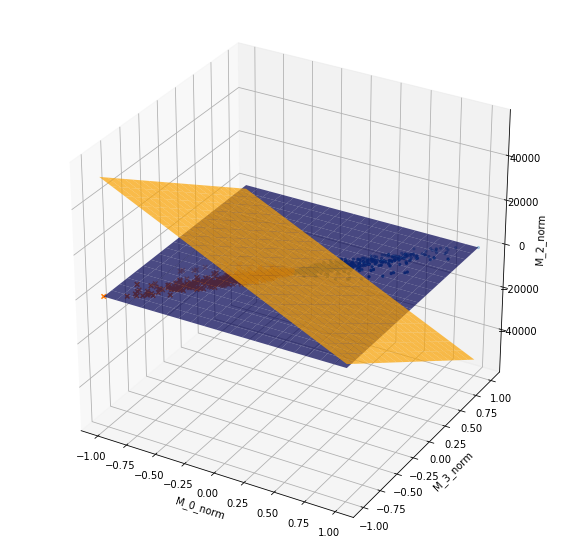

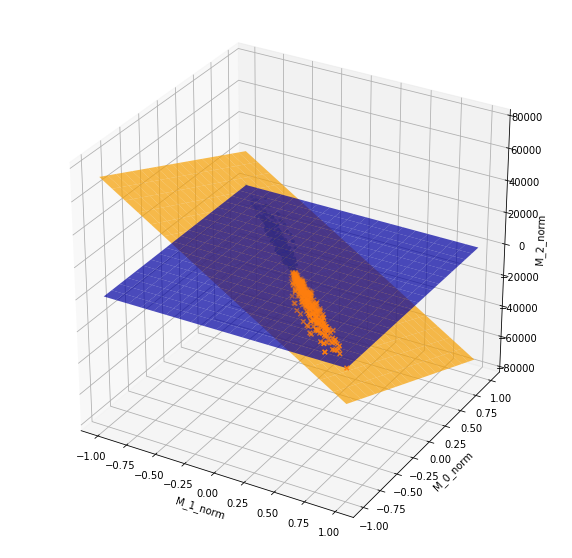

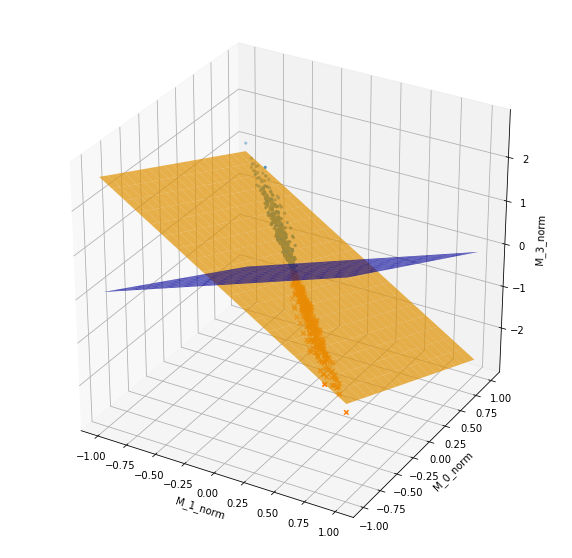

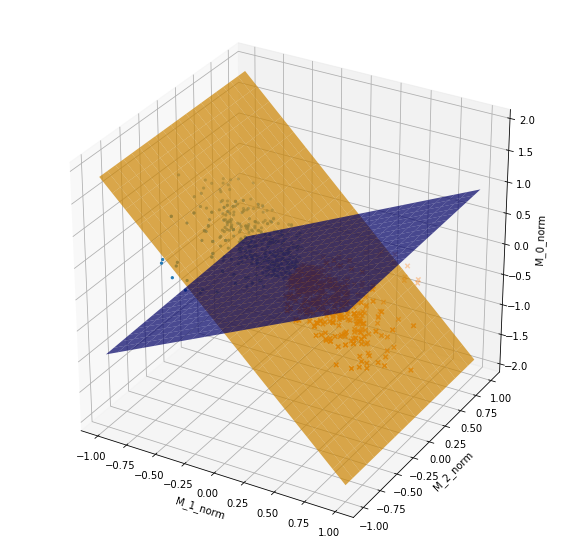

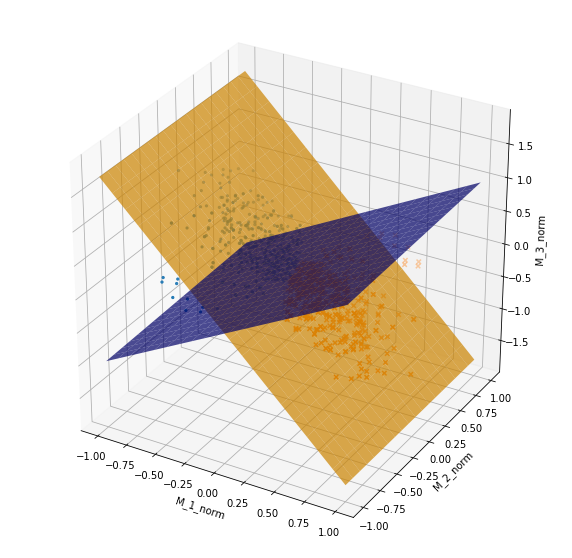

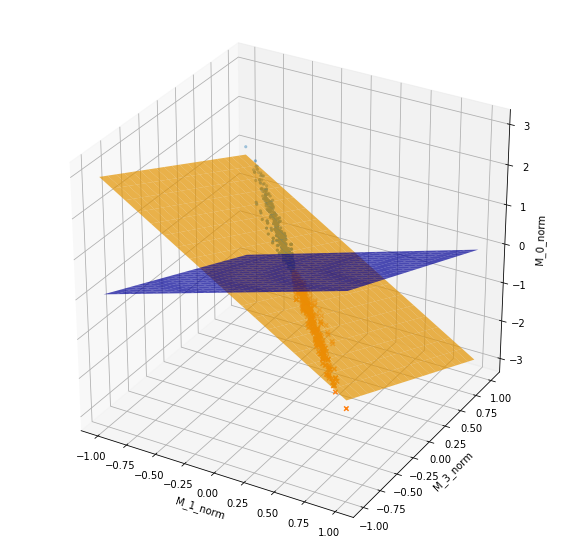

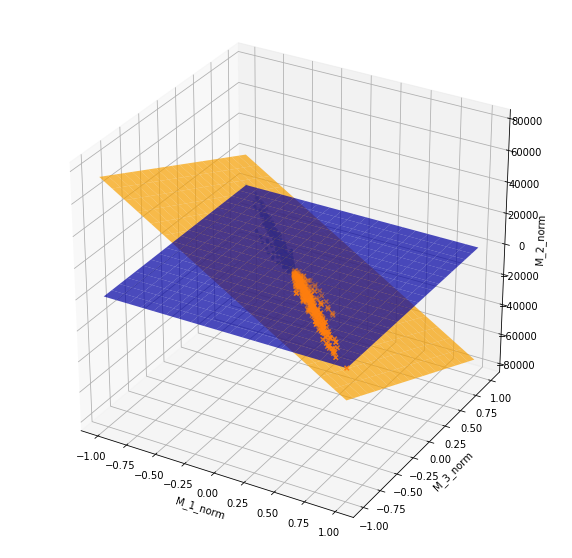

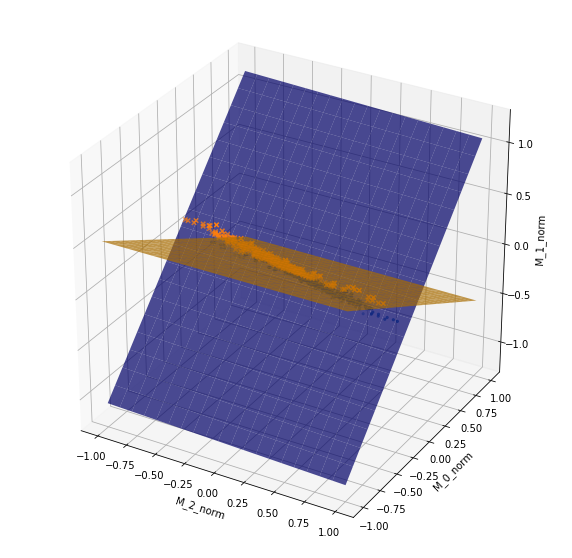

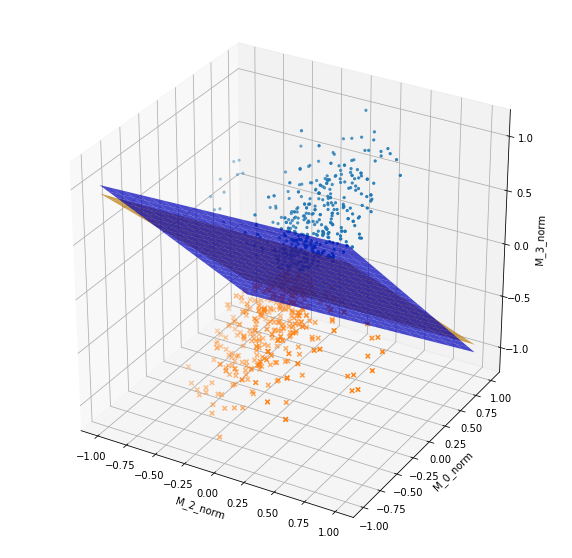

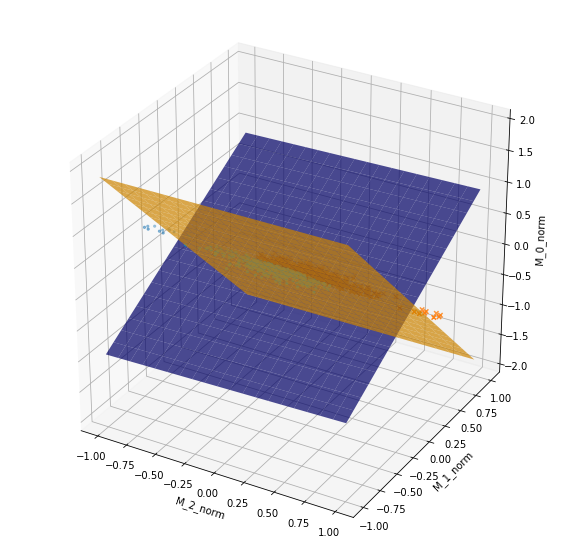

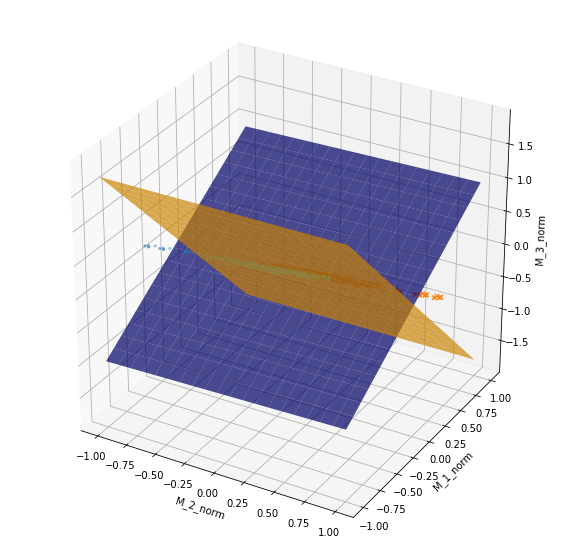

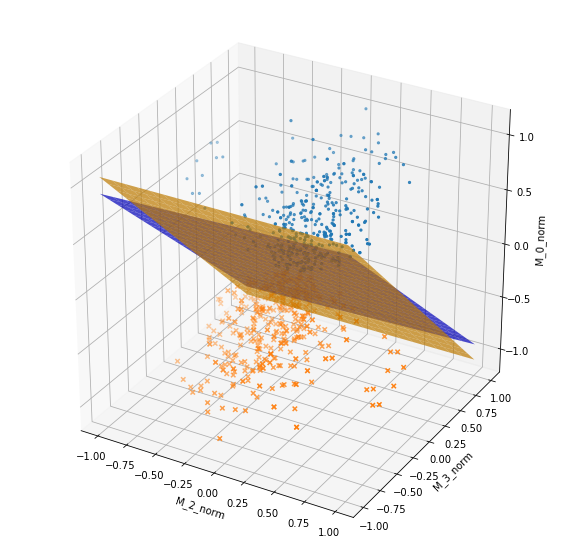

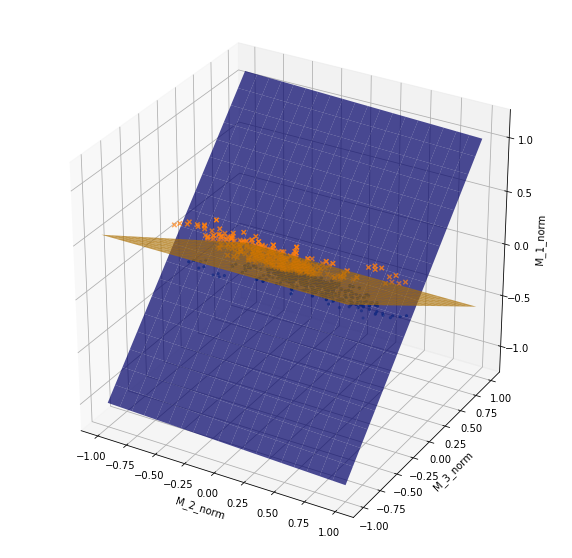

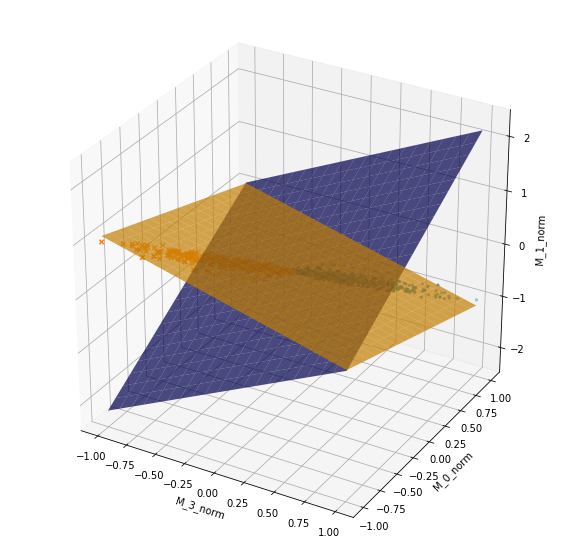

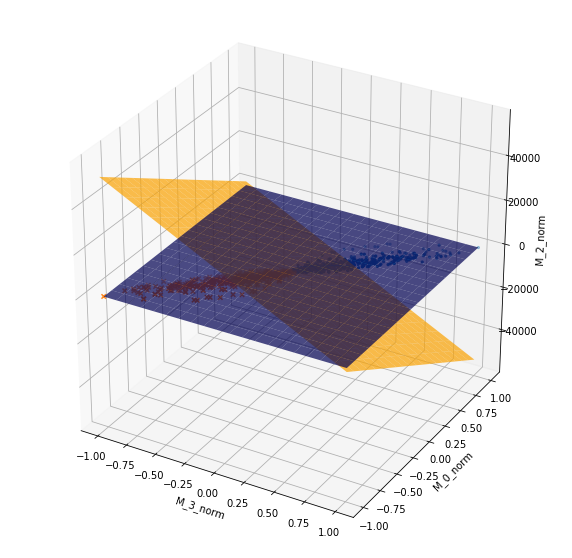

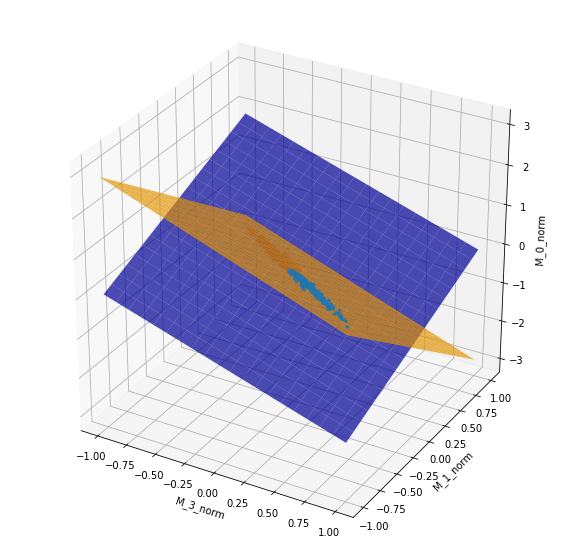

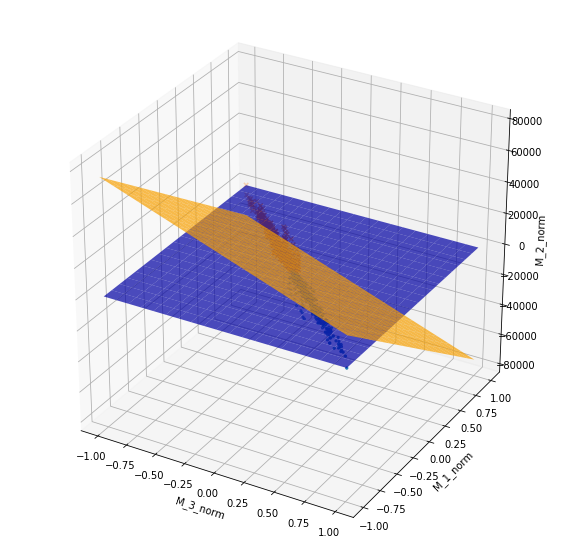

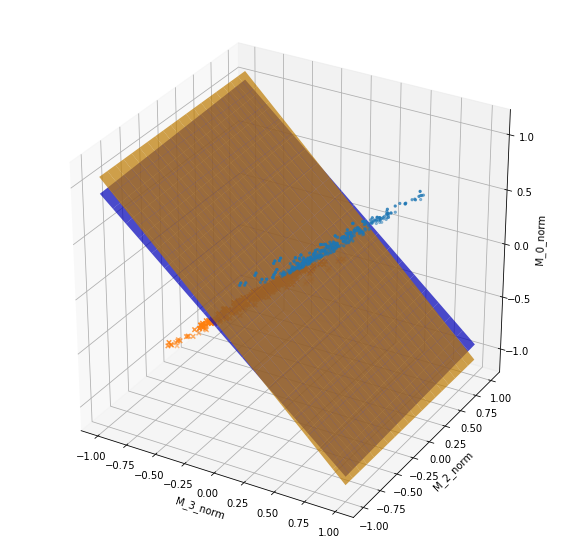

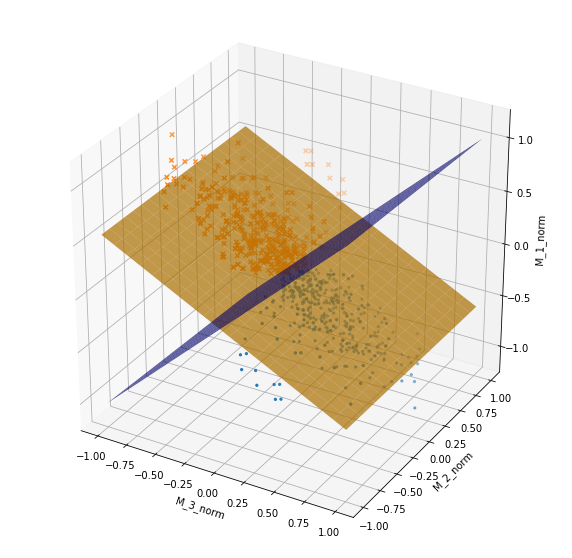

In [175]:
from mpl_toolkits.mplot3d import Axes3D

def module(u):
    ans = 0
    for elem in u:
        ans += elem * elem
    return ans

def sc(u, v):
    ans = 0;
    for i in range(len(u)):
        ans += u[i] * v[i];
    return ans;


def cos_n(u, v):
    return sc(u, v) / np.sqrt(module(u) * module(v))



def model_score(model, X, y, lam, show=False, max_M = [1, 1, 1, 1]):
    model_norm = list(model.coef_[0])
    print('Веса модели с нормализаванными признаками ', model_norm)
    model_coef = [0] * 4
    for i in range(4):
        model_coef[i] = model_norm[i] / max_M[i];
    print('Веса исходной модели ', model_coef)
    print('Заранее известные коэффициенты lam ', lam)
    print('Частота правильных ответов на обучающей выборке ', model.score(X, y))
    print('Косинус угла между векторами lam и model_coef', cos_n(model_coef, lam))
    if show:
        X1 = X[y==1]
        X0 = X[y==-1]
        for i in range(len(X.columns)):
            for j in range(i + 1, len(X.columns)):
                x=np.linspace(-1, 1)
                plt.figure(figsize=(7, 7))
                plt.scatter(x = X1[X.columns[i]], y=X1[X.columns[j]], marker='.')
                plt.scatter(x = X0[X.columns[i]], y=X0[X.columns[j]], marker='x')
                plt.plot(x, (-1)* model_norm[i] / model_norm[j] * x, label='model')
                plt.plot(x, (-1) * (lam[i] * max_M[i]) / (lam[j] * max_M[j]) * x, label='true')
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                plt.legend()
                plt.xlabel(X.columns[i])
                plt.ylabel(X.columns[j])
                plt.grid()
                plt.show()
        for i in range(len(X.columns)):
            for j in range(len(X.columns)):
                for k in range(len(X.columns)):
                    if i == j or j == k or i == k:
                        continue
                    u, v = np.mgrid[-1:1:20j, -1:1:20j]
                    fig = plt.figure(figsize=(10, 10))
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(X1[X.columns[i]], X1[X.columns[j]], X1[X.columns[k]], marker='.')
                    ax.scatter(X0[X.columns[i]], X0[X.columns[j]], X0[X.columns[k]], marker='x')
                    ax.plot_surface(u , v, (-1)* (model_norm[i] * u + model_norm[j] * v) / model_norm[k], alpha=0.7, color='blue')
                    ax.plot_surface(u , v, (-1)* ((lam[i] * max_M[i]) * u + (lam[j] * max_M[j]) * v) / (lam[k] * max_M[k]), alpha=0.7, color='orange')
                    ax.set_xlabel(X.columns[i])
                    ax.set_ylabel(X.columns[j])
                    ax.set_zlabel(X.columns[k])
                    plt.show()
        return model_coef
                

lam = [2, 333, 0.000025, 0.01]
#lam = [0.5 / sigm1, 1 / sigm2, 0.000025, 0.01]
model_lam = model_score(model_norm, X_normalized, y, lam, True, max_M)

In [176]:
def A(lam):
    return (sigm1 * lam[0] - sigm2 * lam[1]) / (2 * lam[3]) - C0

def B(lam):
    return -sigm2 * lam[1] / (2 * lam[3] + 2 * (2 * np.pi) *(2 * np.pi) * lam[2])

A_model, B_model = A(model_lam), B(model_lam)
A_true, B_true = A(lam), B(lam)
A_model, B_model, A_true, B_true

(-5.015072236083675, -0.2819034340728035, -84.95, -45.462983390431454)

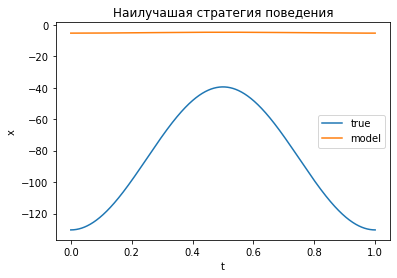

In [177]:
t_space = np.linspace(0, 1, 1001)

def x(A, B, t):
    return A + B * np.cos(2 * np.pi * t)

plt.plot(t_space, x(A_true, B_true, t_space), label='true')
plt.plot(t_space, x(A_model, B_model, t_space), label='model')
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Наилучашая стратегия поведения')
plt.show()